# Assessment 3a: Generating adversarial examples


In this assessment, you are required to generate five adversarial example images to fool a machine learning model into misclassifying them. This assessment is quite similar to the practical session, so please carefully read the practical session and understand its content before you go through this assessment.

The dataset you will be using is FashionMNST, a series of images of different types of clothing. Each image is classified according to 10 different types of clothing.

![fashion-mnist.png](attachment:fashion-mnist.png)

Each training and test example is assigned to one of the following labels:

| Label	| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |:---: | :---: |:---: | :---: |
|  | T-shirt/top| Trouser | Pullover | Dress | Coat | Sandal | Shirt | Sneaker | Bag | Ankle boot |

Now you need to create a list named as "classes" to store these labels in String, and print this list.

Expected outputs:

    ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' ]
print(classes)
print(classes[5])

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Sandal


Before we go through training the deep learning model, please import the necessary packages. These will be the same as those we introduced in the Module 4 and 5 practical activities.

In [2]:

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import numpy as np
import math
import random




<p>Next, we declare some hyper parameters for model training, including <strong>training epochs</strong>, <strong>batch size</strong> and <strong>learning rate</strong>.
    
Training epochs can be set as any integer number greater than 10. Batch size can be set as any number from 32, 64, 100. Learning rate should be set as 0.001</p>


In [15]:

# Hyper Parameters
NUM_EPOCHS = 3
BATCH_SIZE = 100
LEARNING_RATE1 = 0.001



Load the training dataset test dataset. The name of required dataset is "FashionMNIST". To get this dataset, simply replace 'MNIST' in the practical session as 'FashionMNIST'.

In [16]:
# MNIST Dataset
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5],std = [0.5])
                               ])

# Download training dataset
train_dataset = dsets.FashionMNIST(root = './data/',
                            train = True,
                            transform = transform,
                            download = True)

# Download testing dataset
test_dataset = dsets.FashionMNIST(root = './data/',
                           train = False,
                           transform = transform,
                           download = True)

# Data Loader (Input Pipeline)
# The first training dataset for target model
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

# The original test dataset
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False)




Please print the number of how many images from both training dataset and test dataset.</p>

Expected output is:

    The length of training dataset:  60000

    The length of test dataset:  

In [17]:

print("The length of training dataset: ", len(train_dataset))
print("The length of test dataset: ", len(test_dataset))



The length of training dataset:  60000
The length of test dataset:  10000



Show the first 5 images of the training dataset to see what they look like.</p>

In this assessment, you are required to demonstrate and create adversarial examples for the first five images. Simply change the index of the training dataset and create five different variables for five images.

Example for the third image:
    
    img3 = training_dataset[2][0].squeeze(0).data
    

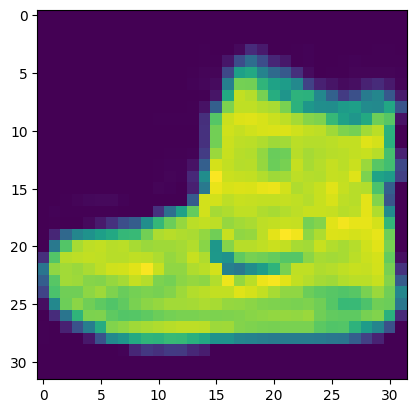

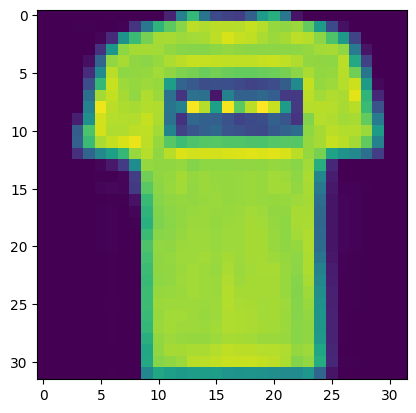

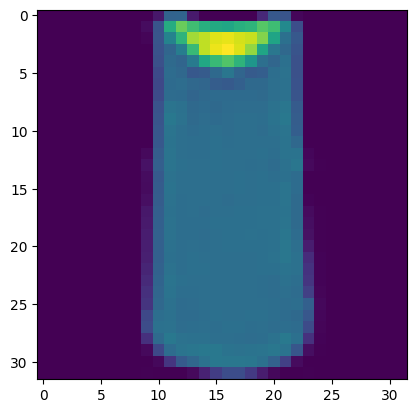

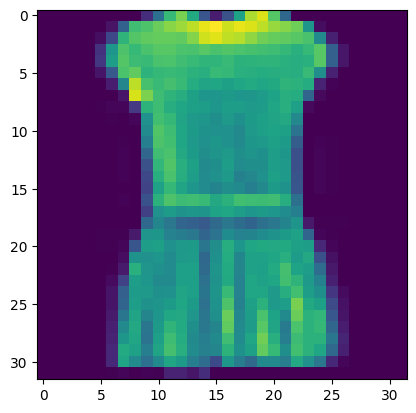

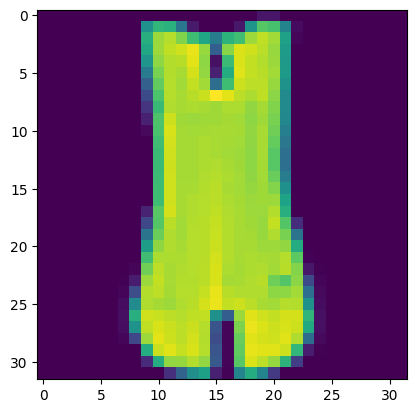

In [18]:
import matplotlib.pyplot as plt
img1 = train_dataset[0][0].squeeze(0).data
img1 = img1.numpy()
plt.imshow(img1)
plt.show()

import matplotlib.pyplot as plt
img2 = train_dataset[1][0].squeeze(0).data
img2 = img2.numpy()
plt.imshow(img2)
plt.show()

import matplotlib.pyplot as plt
img3 = train_dataset[2][0].squeeze(0).data
img3 = img3.numpy()
plt.imshow(img3)
plt.show()

import matplotlib.pyplot as plt
img4 = train_dataset[3][0].squeeze(0).data
img4 = img4.numpy()
plt.imshow(img4)
plt.show()

import matplotlib.pyplot as plt
img5 = train_dataset[4][0].squeeze(0).data
img5 = img5.numpy()
plt.imshow(img5)
plt.show()

<p>In this assessment we will use the same model as our practical activities to build and train the model. Use the code from the practical activity to add the model.</p>

In [19]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)),
            nn.BatchNorm2d(128, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
            nn.ReLU(inplace = True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)),
            nn.BatchNorm2d(256, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
            nn.ReLU(inplace = True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)),
            nn.BatchNorm2d(512, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
            nn.ReLU(inplace = True)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features = 8192, out_features = 50, bias = True),
            nn.Dropout(p = 0.5),
            nn.Linear(in_features = 50, out_features = 10, bias = True)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Define a model cnn belongs to CNN class
classifierModel = Classifier()
# Loss and Optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(classifierModel.parameters(), lr = LEARNING_RATE1)



<p>Let's train our model. We train the model for the number of epochs you set above, which means all training data will pass the model that number times. The training process may take different lengths of time depending on the the processing capability between different devices. Again, you will need to add the correct code from the practical activity.</p>


In [20]:
# Train the Model
for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
#         print(labels)
#         print(type(labels))

#         labels = dirtyLabel(labels, 7, 1)
#         print(labels)
#         print(type(labels))
        images = Variable(images)
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer1.zero_grad()
        outputs = classifierModel(images)

        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()

        if (i + 1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch + 1, NUM_EPOCHS, i + 1, len(train_dataset)//BATCH_SIZE, loss.data))



Epoch [1/3], Iter [100/600] Loss: 0.8234
Epoch [1/3], Iter [200/600] Loss: 0.5330
Epoch [1/3], Iter [300/600] Loss: 0.4943
Epoch [1/3], Iter [400/600] Loss: 0.4259
Epoch [1/3], Iter [500/600] Loss: 0.2685
Epoch [1/3], Iter [600/600] Loss: 0.3262
Epoch [2/3], Iter [100/600] Loss: 0.3024
Epoch [2/3], Iter [200/600] Loss: 0.3533
Epoch [2/3], Iter [300/600] Loss: 0.3932
Epoch [2/3], Iter [400/600] Loss: 0.3021
Epoch [2/3], Iter [500/600] Loss: 0.3417
Epoch [2/3], Iter [600/600] Loss: 0.3991
Epoch [3/3], Iter [100/600] Loss: 0.2492
Epoch [3/3], Iter [200/600] Loss: 0.3073
Epoch [3/3], Iter [300/600] Loss: 0.2769
Epoch [3/3], Iter [400/600] Loss: 0.3577
Epoch [3/3], Iter [500/600] Loss: 0.3020
Epoch [3/3], Iter [600/600] Loss: 0.2707



<p>Let's test our model using test dataset. You are required to show the test accuracy of 1000 test images. You are also required to show the test accuracy of the model on each class (classes' names are created above already. Simply use classes[n], n is an integer of the label. For example, 'T-shirt/top' is classes[0])</p>

Example output:

Test Accuracy of the model on the 10000 test images: ** %

Test Accuracy of the model on the class T-shirt/top is: ** %

...

In [21]:

# Test the Model
classifierModel.eval() # Change model to 'eval' mode (BN uses moving mean/var).

correct = 0
total = 0
correct0 = correct1 = correct2 = correct3 = correct4 = correct5 = correct6 = correct7 = correct8 = correct9 = 0
total0 = total1 = total2 = total3 = total4 = total5 = total6 = total7 = total8 = total9 = 0

names = locals()

for images, labels in test_loader:
    images = Variable(images)
    outputs = classifierModel(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

    labels = labels.tolist()
    for l in range(0, 10):
        if labels[0] == l:
            names["total" + str(l)] = names["total" + str(l)] + 1
            predicted = predicted.tolist()
            if predicted[0] == labels[0]:
                names["correct" + str(l)] = names["correct" + str(l)] + 1

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * float(correct) / total))

for num in range(0, 10):
    print("Test Accuracy of the model on the class",classes[num], "is: %d %%" % (100 * float(names["correct" + str(num)]) / names["total" + str(num)]))



Test Accuracy of the model on the 10000 test images: 90 %
Test Accuracy of the model on the class T-shirt/top is: 84 %
Test Accuracy of the model on the class Trouser is: 98 %
Test Accuracy of the model on the class Pullover is: 87 %
Test Accuracy of the model on the class Dress is: 92 %
Test Accuracy of the model on the class Coat is: 75 %
Test Accuracy of the model on the class Sandal is: 97 %
Test Accuracy of the model on the class Shirt is: 76 %
Test Accuracy of the model on the class Sneaker is: 95 %
Test Accuracy of the model on the class Bag is: 98 %
Test Accuracy of the model on the class Ankle boot is: 98 %



Test the predicted label for the first image of training dataset which is already printed out above.

Expected output:

    "Trouser"


In [49]:
classifierModel.eval()
images = torch.tensor(img1, dtype = torch.float32)
images = images.unsqueeze(0)
images = images.unsqueeze(0)
images = Variable(images)
outputs = classifierModel(images)
_, predicted = torch.max(outputs.data, 1)
print(classes[predicted])


Ankle boot


## Make your adversarial images

To make adversarial images, some peturbed noise with the same shape as the original images(32 * 32) should be generated. As the demonstration in the pratical session, the adversarial image maybe not visually clear when the noise is large, and also the adversarial image cannot fool the deep learning model when the noise is small. Please carefully scale the noise. The task is to generate the small enough noise to fool the deep learning model.

And then add generated noise on 5 original images, and print out 5 noisy images. Please note, you only need to generate noise and make adversarial examples for first five images we print above.

Show 5 adversarial images, their original label, and their predicted labels from the deep learning model.
Also print out 5 original images and 5 adversarial images as comparision.

In [58]:
noiseMatrix = np.random.random((32,32))
print(noiseMatrix)


[[0.79807029 0.77596214 0.39091434 ... 0.80922717 0.18293194 0.17035545]
 [0.24589056 0.17123081 0.6688604  ... 0.73719898 0.39706273 0.22475639]
 [0.31863337 0.84595326 0.63535337 ... 0.37351567 0.45962784 0.755197  ]
 ...
 [0.36183402 0.89895811 0.98094576 ... 0.30109133 0.79902739 0.20482358]
 [0.50819803 0.12728965 0.51605599 ... 0.70076929 0.03067292 0.36790939]
 [0.58320811 0.2171732  0.39064703 ... 0.69027259 0.72526651 0.52319053]]


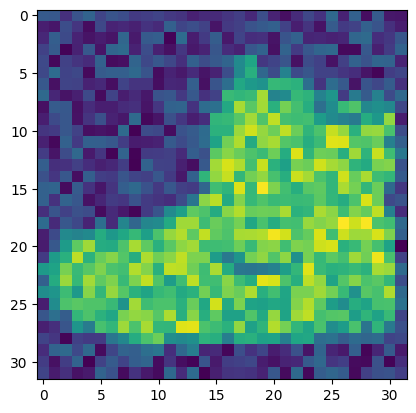

In [62]:
noisyimg1 = img1 +noiseMatrix
plt.imshow(noisyimg1)
plt.show()


In [63]:
images = torch.tensor(noisyimg1, dtype = torch.float32)
images = images.unsqueeze(0)
images = images.unsqueeze(0)
print(images.shape)
print(images.type())


torch.Size([1, 1, 32, 32])
torch.FloatTensor


In [64]:
classifierModel.eval()
images = Variable(images)
outputs = classifierModel(images)
_, predicted = torch.max(outputs.data, 1)
print(classes[predicted])


Shirt


In [29]:
noiseMatrix = np.random.random((32,32))
print(noiseMatrix)

[[6.95727774e-02 2.54386996e-01 5.54456020e-01 ... 6.89515576e-01
  1.54415105e-01 3.64358921e-01]
 [9.20822400e-01 2.47792084e-01 5.97192086e-01 ... 1.06783323e-01
  8.62424232e-01 4.33071859e-01]
 [4.48006577e-02 2.98899372e-01 7.99392969e-02 ... 4.42040893e-01
  6.11878075e-01 2.27823317e-01]
 ...
 [9.37589949e-01 1.15989198e-01 6.87048077e-01 ... 5.96571234e-04
  7.62937331e-01 1.94218532e-01]
 [5.03500414e-01 7.25787836e-01 7.21641106e-01 ... 6.29595517e-01
  3.04150374e-01 7.94908278e-01]
 [2.53621261e-01 9.69033654e-01 4.16519073e-01 ... 4.77717900e-01
  4.22281095e-01 9.58593090e-01]]


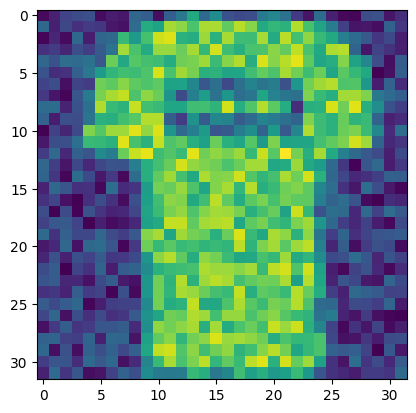

In [30]:
noisyimg2 = img2 + noiseMatrix
plt.imshow(noisyimg2)
plt.show()


In [31]:
images = torch.tensor(noisyimg2, dtype = torch.float32)
images = images.unsqueeze(0)
images = images.unsqueeze(0)
print(images.shape)
print(images.type())


torch.Size([1, 1, 32, 32])
torch.FloatTensor


In [32]:
classifierModel.eval()
images = Variable(images)
outputs = classifierModel(images)
_, predicted = torch.max(outputs.data, 1)
print(classes[predicted])


Shirt


In [33]:
noiseMatrix = np.random.random((32,32))
print(noiseMatrix)

[[0.53340497 0.62109198 0.63860222 ... 0.69478575 0.58392804 0.7553414 ]
 [0.43403084 0.29416847 0.04385774 ... 0.24591206 0.64700382 0.04125294]
 [0.50187128 0.84591059 0.78984103 ... 0.69717224 0.40674708 0.76360937]
 ...
 [0.00524772 0.97225572 0.50648064 ... 0.10919438 0.08239483 0.76593147]
 [0.85530859 0.59546396 0.80253516 ... 0.57314945 0.72873749 0.94033354]
 [0.55524628 0.38185836 0.54082179 ... 0.0699159  0.76191514 0.85799188]]


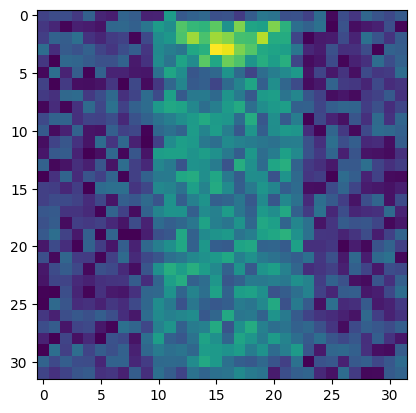

In [34]:
noisyimg3 = img3 + noiseMatrix
plt.imshow(noisyimg3)
plt.show()


In [35]:
images = torch.tensor(noisyimg3, dtype = torch.float32)
images = images.unsqueeze(0)
images = images.unsqueeze(0)
print(images.shape)
print(images.type())


torch.Size([1, 1, 32, 32])
torch.FloatTensor


In [36]:
classifierModel.eval()
images = Variable(images)
outputs = classifierModel(images)
_, predicted = torch.max(outputs.data, 1)
print(classes[predicted])


Bag


In [37]:
noiseMatrix = np.random.random((32,32))
print(noiseMatrix)


[[0.67593494 0.94922181 0.72101554 ... 0.13444832 0.17994665 0.43872331]
 [0.37899118 0.13017116 0.88090437 ... 0.37059868 0.12580701 0.53539969]
 [0.71812327 0.13514844 0.99241825 ... 0.72818648 0.03001473 0.88433657]
 ...
 [0.59174094 0.98042365 0.38947952 ... 0.26427228 0.05777414 0.99356191]
 [0.49808107 0.40890743 0.73177964 ... 0.1646963  0.33731093 0.21819456]
 [0.76652704 0.13387264 0.66692026 ... 0.97050971 0.01369741 0.53315367]]


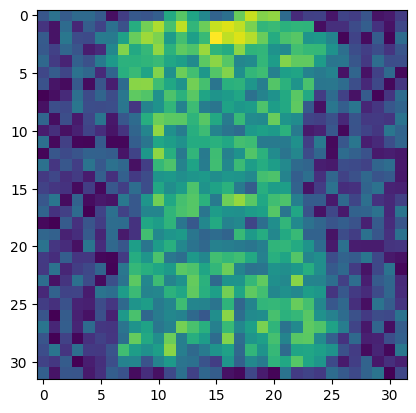

In [38]:
noisyimg4 = img4 + noiseMatrix
plt.imshow(noisyimg4)
plt.show()


In [39]:
images = torch.tensor(noisyimg4, dtype = torch.float32)
images = images.unsqueeze(0)
images = images.unsqueeze(0)
print(images.shape)
print(images.type())


torch.Size([1, 1, 32, 32])
torch.FloatTensor


In [45]:
classifierModel.eval()
images = Variable(images)
outputs = classifierModel(images)
_, predicted = torch.max(outputs.data, 1)
print(classes[predicted])


Shirt


In [41]:
noiseMatrix = np.random.random((32,32))
print(noiseMatrix)

[[0.3615576  0.50663918 0.53203734 ... 0.83636536 0.80230865 0.03660918]
 [0.47134858 0.4971211  0.27441848 ... 0.14215745 0.50056227 0.63682598]
 [0.59865778 0.22540092 0.7385403  ... 0.48082261 0.95473539 0.97388257]
 ...
 [0.95134119 0.98385289 0.12975903 ... 0.66434895 0.726451   0.60470272]
 [0.66964156 0.94382819 0.65179952 ... 0.95314624 0.37154231 0.40371815]
 [0.44252937 0.41997338 0.50565223 ... 0.65316316 0.5366286  0.93307201]]


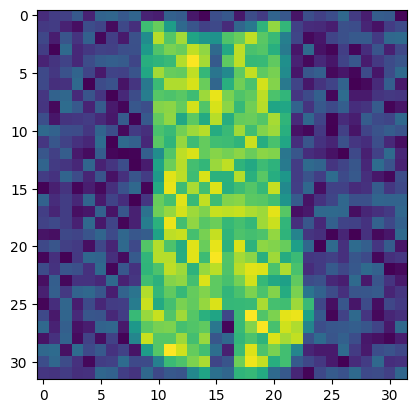

In [42]:
noisyimg5 = img5 + noiseMatrix
plt.imshow(noisyimg5)
plt.show()


In [46]:
images = torch.tensor(noisyimg5, dtype = torch.float32)
images = images.unsqueeze(0)
images = images.unsqueeze(0)
print(images.shape)
print(images.type())


torch.Size([1, 1, 32, 32])
torch.FloatTensor


In [47]:
classifierModel.eval()
images = Variable(images)
outputs = classifierModel(images)
_, predicted = torch.max(outputs.data, 1)
print(classes[predicted])


Shirt
